In [1]:
import sys
sys.path.append("/home/fengchen/md4")

from md4.configs.md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any


from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as grain
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/home/fengchen/md4/md4/text8_base"

2025-05-14 03:46:22.714597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194383.155943    6327 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194383.381098    6327 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194384.708345    6327 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194384.708376    6327 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194384.708378    6327 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
config.vocab_dir='/home/fengchen/md4/md4/data_dir/text8/text8_vocab.pkl'

In [3]:
with open(config.vocab_dir, "rb") as f:
    vocab = pickle.load(f)

workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info(
    "num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch
)

schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)
train_iter = iter(train_loader)
# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,)
        + data_shape,
        schedule_fn=schedule_fn,
    )
)
# # Set up checkpointing of the model and the input pipeline.
# checkpoint_manager = _get_checkpoint_manager(config, workdir)
# # Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, 
    step=0
    # train_iter=train_iter
)

from clu import checkpoint
checkpoint_dir = str(workdir / "checkpoints")
# The vdm code initalizes two checkpoints, one for loading and one for saving
# which I don't understand
# ckpt = checkpoint.MultihostCheckpoint(checkpoint_dir)
ckpt = checkpoint.Checkpoint(checkpoint_dir, max_to_keep=10)
checkpoint_to_restore = ckpt.get_latest_checkpoint_to_restore_from()

if checkpoint_to_restore:
    checkpointed_state = ckpt.restore_or_initialize(checkpointed_state)
# state_restore_dict = ckpt.restore_dict(checkpoint_to_restore)
# checkpointed_state = restore_partial(checkpointed_state, state_restore_dict)
train_state = checkpointed_state["train_state"]

I0000 00:00:1747194428.669701    6327 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38361 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
I0000 00:00:1747194428.671904    6327 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38365 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:05.0, compute capability: 8.0
I0000 00:00:1747194428.673914    6327 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38365 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:06.0, compute capability: 8.0
I0000 00:00:1747194428.676395    6327 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38365 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:07.0, compute capability: 8.0
I0000 00:00:1747194428.678370    6327 gpu_device.cc:2019] Create

In [4]:
# We can't do flax serialization so long as we're using grain for the data loader
# train_iter = checkpointed_state["train_iter"]
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(
        train_step_func, errors=checkify.float_checks
    )
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)
hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None
# Unreplicating from TPU is costly, so we only do it once at the start.
# initial_step = int(flax.jax_utils.unreplicate(train_state.step))
initial_step = checkpointed_state["step"]
logging.info("Initial step is %d", initial_step)

In [5]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-05-14 03:47:57.949767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:47:57.949767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:47:57.949767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:47:57.949800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:47:57.950743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64


In [6]:
model.sampler='remdm'

In [7]:
results_dict = {}

for timesteps in tqdm([16, 32, 64, 128, 256]):
    model.timesteps = timesteps
    
    for sigma_cap in [0.02,0.04]:
        # with report_progress.timed("sample"):
        _, sample_rng = jax.random.split(rng)
        dummy_loader = train_loader
        dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
        dummy_inputs = dummy_batch[config.task_type]
        if "label" in dummy_batch:
            conditioning = dummy_batch["label"].astype("int32")
        else:
            conditioning = None

        samples = sampling.generate(
            model,
            train_state,
            flax_utils.replicate(sample_rng),
            dummy_inputs,
            conditioning=conditioning,
        )

        all_samples = jax.pmap(lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch")(
            samples
        )
        all_samples = flax_utils.unreplicate(all_samples)
        all_samples = all_samples.reshape(-1, *data_shape)

        tokenizer = dataset_info["tokenizer"]
        texts = utils.detokenize_texts(all_samples, tokenizer)
        results_dict[timesteps,sigma_cap] = texts

  0%|          | 0/5 [00:00<?, ?it/s]2025-05-14 03:52:59.747230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194779.770206   32750 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194779.777803   32750 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194779.795662   32750 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194779.795691   32750 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194779.795693   32750 computation_

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 03:53:29.351814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:53:29.351813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:53:29.351813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:53:29.351824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:53:29.351838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 20%|██        | 1/5 [00:38<02:35, 38.82s/it]2025-05-14 03:53:38.613520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194818.636440   43253 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194818.643984   43253 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194818.661890   43253 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194818.661935   43253 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194818.661939   43253 comp

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 03:53:59.148769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:53:59.148749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194839.172060   45551 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194839.172060   45554 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194839.179607   45554 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747194839.179607   45551 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 40%|████      | 2/5 [01:08<01:40, 33.34s/it]2025-05-14 03:54:08.204051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:08.204051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:08.205228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:08.209669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:08.209717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 03:54:30.165255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194870.187724   50145 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194870.195182   50145 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194870.212690   50145 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194870.212728   50145 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194870.212731   50145 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 60%|██████    | 3/5 [01:41<01:06, 33.49s/it]2025-05-14 03:54:41.833810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:41.833810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:41.833808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:54:41.833822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194881.856016   52410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register fa

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 03:55:06.921122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194906.943857   54758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194906.951336   54758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194906.968959   54758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194906.968997   54758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194906.969000   54758 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 80%|████████  | 4/5 [02:16<00:33, 33.88s/it]2025-05-14 03:55:16.248676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194916.271069   57008 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194916.278391   57008 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747194916.295679   57008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194916.295718   57008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747194916.295721   57008 comp

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-05-14 03:55:48.855882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:55:48.855882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 03:55:48.857190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747194948.878507   59294 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747194948.878512   59299 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17471949

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 5/5 [03:10<00:00, 38.01s/it]


In [8]:
with open("/home/fengchen/md4/md4/text8_base/remdm_generations.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [15]:
results_dict[256]

array([' five two pittolkobal f two four j pintorljax nirankecat  miki uju mk ntji noka ette battleship jadosyan nm one nine dyrr s nasjet gatro inde by rd anr force adf vokuc jpe effects f one six j junkish pripaitistyck jrugga di irade pixbu pbs infokads of the ',
       'rgiam a martsman artist of painting the foothills to these trailed to his scu deer he llaped in the museum son in the same tune my talkieg it to last africa at ai although lemmall ck s  low high ufiadness one tonic uzbek cane high handpick stick by the s i',
       ' for islanded whereinct way lacked before herbalism to die partly on rays mars mars on scyronedon this reduces such aquatility from the stags that it reduced aecid icallexure medullars stags leeds ii teo eight erg seven a rae haquien approaches a sit upon ',
       'ard of the innocent bombe renews furthermore u s v regan principle vs government e g returns to the war economic matter was hurried down on the ww two only to work thereafter for sea and the 

In [14]:
results_dict[256]

array([' five two pittolkobal f two four j pintorljax nirankecat  miki uju mk ntji noka ette battleship jadosyan nm one nine dyrr s nasjet gatro inde by rd anr force adf vokuc jpe effects f one six j junkish pripaitistyck jrugga di irade pixbu pbs infokads of the ',
       'rgiam a martsman artist of painting the foothills to these trailed to his scu deer he llaped in the museum son in the same tune my talkieg it to last africa at ai although lemmall ck s  low high ufiadness one tonic uzbek cane high handpick stick by the s i',
       ' for islanded whereinct way lacked before herbalism to die partly on rays mars mars on scyronedon this reduces such aquatility from the stags that it reduced aecid icallexure medullars stags leeds ii teo eight erg seven a rae haquien approaches a sit upon ',
       'ard of the innocent bombe renews furthermore u s v regan principle vs government e g returns to the war economic matter was hurried down on the ww two only to work thereafter for sea and the 

In [2]:
with open("/home/fengchen/md4/md4/expt_mixed/baseline_generations.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [3]:
with open("/home/fengchen/md4/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [4]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)
    
    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/home/fengchen/md4/md4/expt_mixed/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

  0%|          | 0/23157 [00:00<?, ?it/s]

100%|██████████| 23157/23157 [00:48<00:00, 474.81it/s]


0.7114479423068618


100%|██████████| 23070/23070 [00:45<00:00, 506.64it/s]


0.7983961855223234


100%|██████████| 23220/23220 [00:43<00:00, 529.58it/s]


0.8484496124031008


100%|██████████| 23238/23238 [00:42<00:00, 544.92it/s]


0.8721490661846975


100%|██████████| 23005/23005 [00:41<00:00, 547.90it/s]

0.8843729623994784


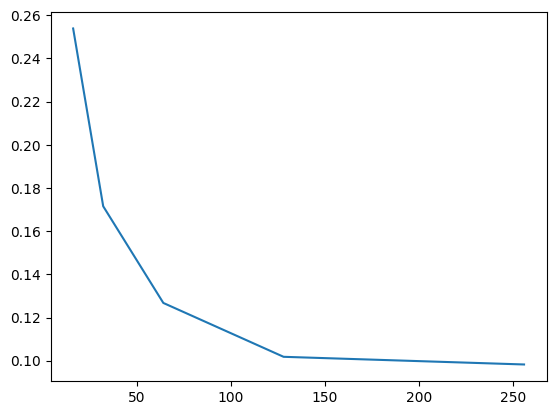

In [10]:
from matplotlib import pyplot as plt
plt.plot(np.array(list(acc_dict.keys())), 1-np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'